# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('/Users/siriuslee/ast596_2020_Spring/data/03/R11ceph.dat')
hosts = ceph.list_hosts()

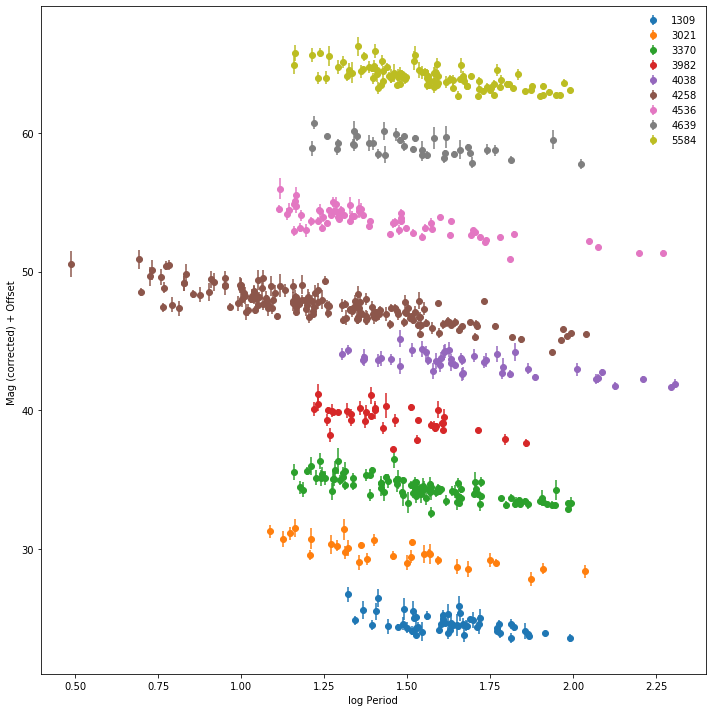

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


According to fuction (1) in Riess et al., 2011:
$$m_{W,i,j} = (\mu_{0,i} - \mu_{0,4258} )+ zp_{W,4258} + b_WlogP_{i,j}$$
Riess et al., (2011) explained that values of the nuisance parameters were determined by minimizing the $\chi^2$ for the global fit to all Cepheid data.
$$\chi^2 = \sum (\dfrac{m - b_WlogP_{i,j} - zp_{W,4258} - (\mu_{0,i} - \mu_{0,4258} )}{\sigma_{int}})^2$$
From the observation and cepheids.py, the negtive log likelihood is:
$$-logL = 0.5\chi^2$$
$$-logL = 0.5\sum (\dfrac{m - b_WlogP_{i,j} - zp_{W,4258} - (\mu_{0,i} - \mu_{0,4258} )}{\sigma_{int}})^2$$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

From the equation (1) (Riess et al., 2011):
$\mu_{0,i}$ represents the reddening-free distances, and the fit parameters $(\mu_{0,i} - \mu_{0,4258})$ shows the relative distance between hosts and NGC 4258. $zp_{W,4258}$ is the intercept of the P-L relation plots, and $b_{w}$ is the slope of the plots. The intercept is positive and slope is negtive according to the plot.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [3]:
%matplotlib inline
import numpy as np
import emcee
import matplotlib.pyplot as plt

# According to fuction (1) in Riess et al., 2011:
def model(a, logP, b):
    m = a*logP + b
    return m

def log_likelihood(logP, mobs, sigma, theta):
    a, b = theta
    return -0.5*np.sum((mobs - model(a, logP, b))**2/(sigma**2))

# def log_prior(a, b):
#     amin,amax = -10.0, 0
#     bmin,bmax = 20.0, 30.0
#     if (b > bmin)*(b < bmax):
#         value = 0.0
#     else:
#         value = -np.inf
#     if (a > amin)*(a < amax):
#         value += 0.0
#     else:
#         value += -np.inf    
#     return value
def log_prior(a, b):
    if -10 < a < 0 and 20 < b < 30:
        return 0.0
    return -np.inf

def log_posterior(theta, logP, mobs, sigma = sigma_obs):
#     a, b = x
    return log_likelihood(logP,mobs,sigma, theta) + log_prior(theta[0], theta[1])

# def loss(theta, mobs = mobs, logP =logP):
#     l = np.sum((mobs - model(theta[0], logP, theta[1]))**2)
#     return l

# def chisquare(theta, logP = logP, mobs = mobs, sigma = sigma_obs):
#     a, b = theta
#     chisq = np.sum((mobs - model(a, logP, b) / sigma)**2)

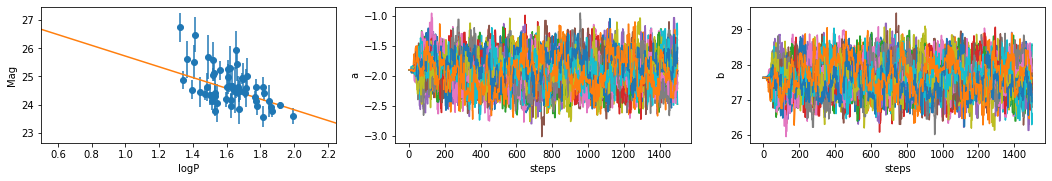

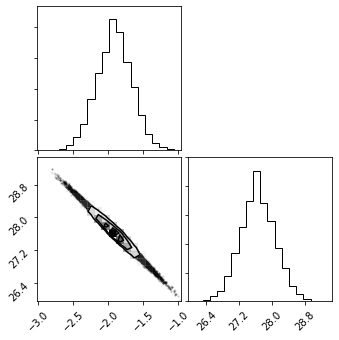

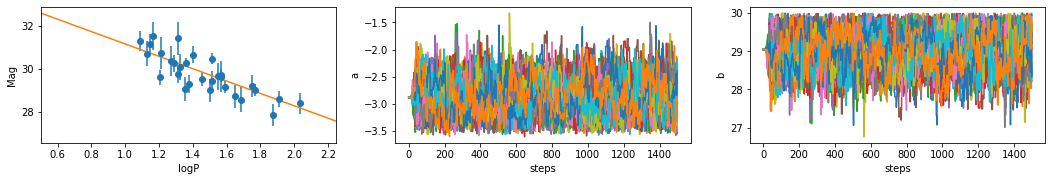

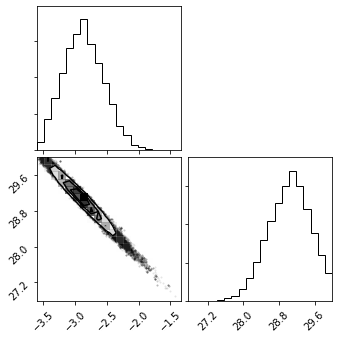

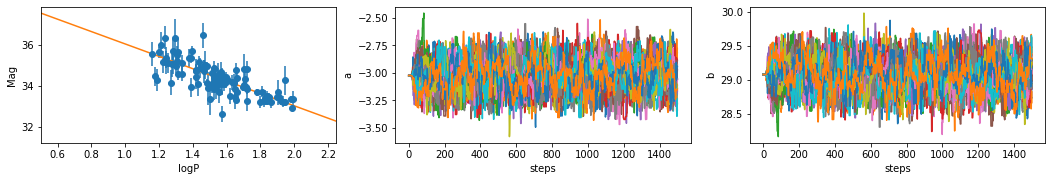

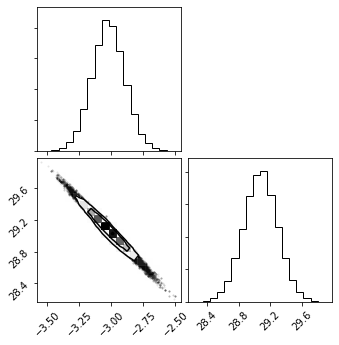

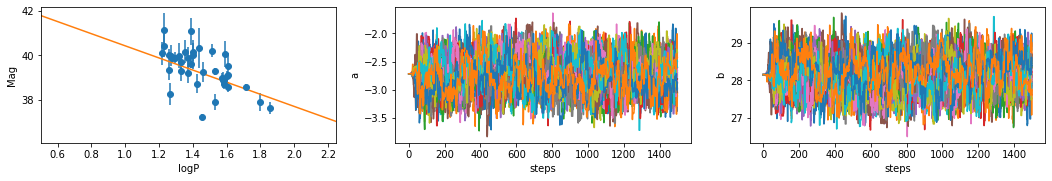

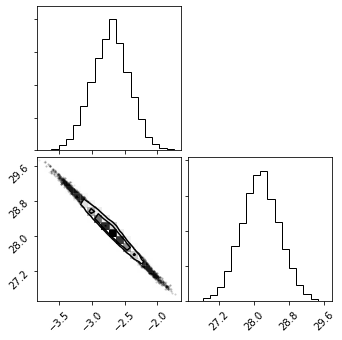

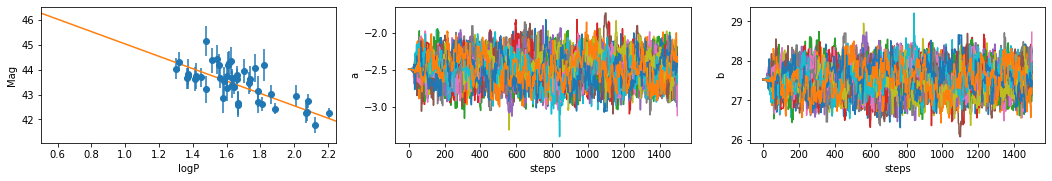

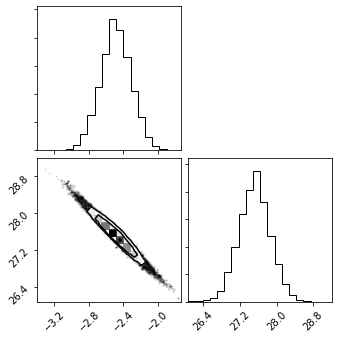

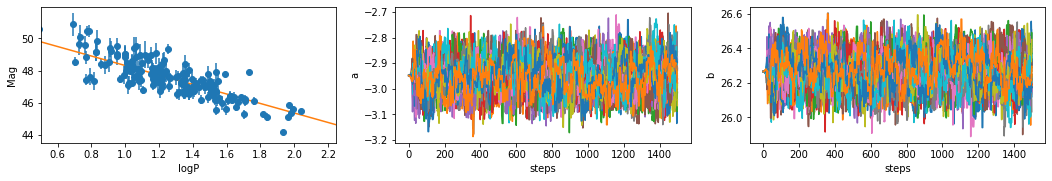

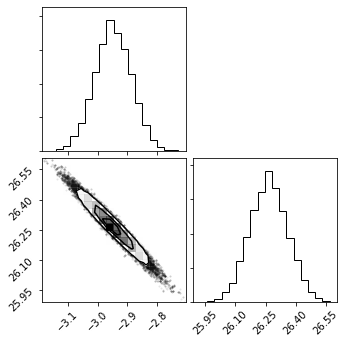

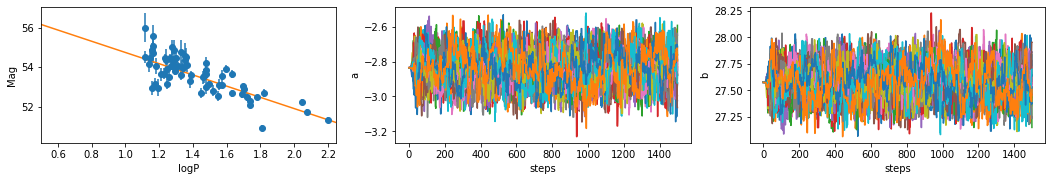

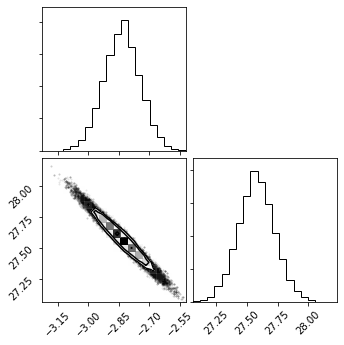

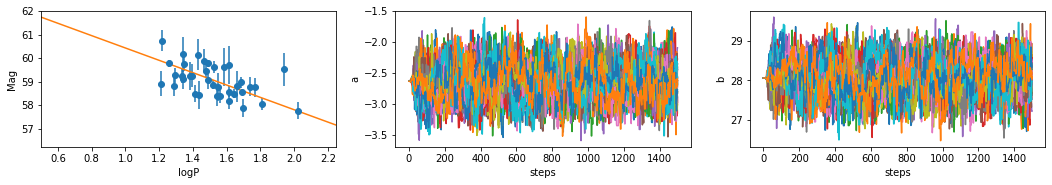

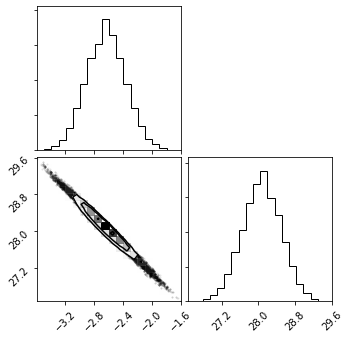

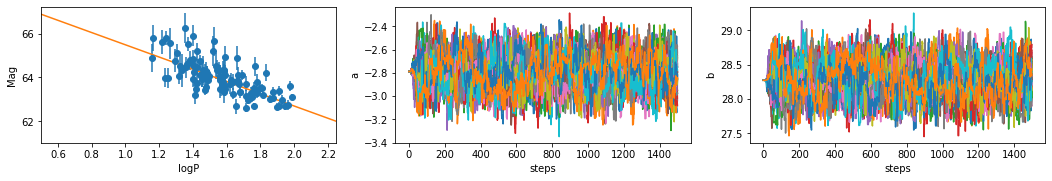

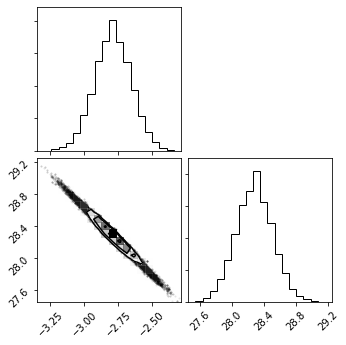

In [4]:
from scipy import optimize
import corner

xfit = np.linspace(0.50, 2.50, num = 100)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    a = -3
    b = 27
    initial = np.array([-3, 27])

    theta = optimize.minimize(ceph.negative_log_likelihood, np.array([-3,27]), bounds = [(-10,0),(20,30)])
#     theta = optimize.minimize(loss, np.array([-3,27]), args = (logP, mobs))

    am, bm = theta.x
#     xfit = np.linspace(0.50, 2.50, num = 100)
    pos = theta.x + (1e-4 * np.random.randn(32,2))
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[logP, mobs, sigma_obs])
    sampler.run_mcmc(pos, 1500)
    
    sample = sampler.get_chain()
#     sample = sampler.chain[:, 1500:, :].reshape(2, ndim)
    steps = np.arange(0, 1500)
#     print(sample)

    fig = plt.figure(figsize = (18,2.5))
    ax1 = plt.subplot(1,3,1)
    ax2 = plt.subplot(1,3,2)
    ax3 = plt.subplot(1,3,3)

    ax1.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o')
    ax1.plot(xfit, model(am, xfit, bm)+(5*i))
    ax1.set_xlim(0.50, 2.25)
    ax1.set_xlabel('logP')
    ax1.set_ylabel('Mag')
    
    ax2.plot(steps, sample[:,:,0])
    ax2.set_xlabel('steps')
    ax2.set_ylabel('a')

    ax3.plot(steps, sample[:,:,1])
    ax3.set_xlabel('steps')
    ax3.set_ylabel('b')
    
    sample2 = sampler.get_chain(flat = True)
    fig = corner.corner(sample2, label = ['a', 'b'])

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

According to the paper, equation 3 is:
$$m^{0}_{v,i} = (\mu_{0, i} - \mu{0,4258}) + m^{0}_{v,4258}$$
equation 4 is:
$$log H_0 = \dfrac{(m^{0}_{v,4258} - \mu_{0, 4258}) + 5a_v + 25}{5} $$
From equation 3 :
$$m^{0}_{v,4258} - \mu{0,4258} = m^{0}_{v,i} - \mu_{0, i}$$
$$log H_0 = \dfrac{(m^{0}_{v,i} - \mu_{0, i}) + 5a_v + 25}{5} = \dfrac{(m^{0}_{v,i} + 5a_v) - (\mu_{0, i} - \mu_{0, 4258}) - \mu_{0, 4258} + 25}{5}$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [15]:
# From Table 3 (Riess et al., 2011):
# m_v,i + 5a_v (adjust the order):
m_5a = np.array([16.768, 16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274])
# mu_0,i - mu_0,4258 (adjust the order):
delta_mu = np.array([3.276, 3.138, 2.835, 2.475, 2.396, 1.567, 2.383, 2.461])

# distance (Humphreys et al., 2013):
mu4258 = 5* np.log10(7.6*10**6 / 10)

In [16]:
mu_4258 = mu4258* np.ones([1,8])
# From Q4 logH0 function:
logH0 = (m_5a - delta_mu - mu_4258 + 25) / 5

In [17]:
H0 = np.array([])
for i in range(0, 8):
    h0 = 10**logH0[0,i]
    H0 = np.append(H0, h0)

In [18]:
H0

array([65.70318273, 67.82446984, 72.64176833, 65.28094126, 66.09770915,
       68.42052586, 70.89023364, 76.17043007])

In [19]:
mean_H0 = np.mean(H0)
median_H0 = np.median(H0)

print('Mean of estimated H0:' + str(mean_H0))
print('Median of estimated H0:' + str(median_H0))

Mean of estimated H0:69.12865760983377
Median of estimated H0:68.12249784978654
